# Get and explore dataset

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
import numpy as np
import re
import math
import pandas as pd

# Preprocessing modules
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Tensorflow stuff
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import tensorflow as tf

In [46]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [47]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [67]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [49]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [50]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative)

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
# Had to change the import because it was not working so fixed some things.
from tensorflow.keras.utils import to_categorical
labels = to_categorical(to_numeric_label(word_labels))

Mean Words: 24.676519799219186
Standard deviation review:  11.284051928842775
Number of unique words: 2559


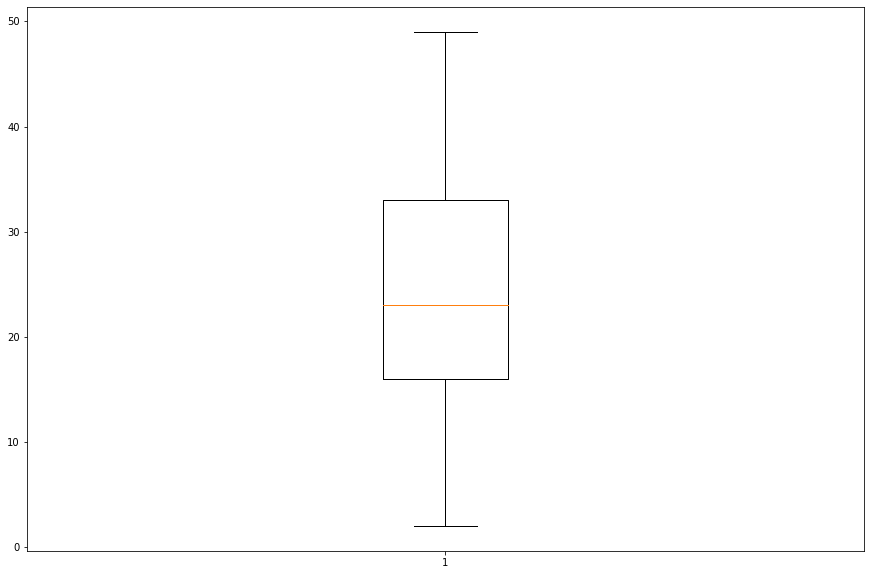

In [51]:
# Write some code to investigate the dataset. 
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
# I was thinking about removing whitespaces from reviews but i don't think that's how i should
# do it so.
def mean(data):
    buffer = 0
    for i in data:
        buffer += len(i)
        
    return buffer / len(data)

# I had a hard time deciding to use either population or sample variance.... I chose population.
# I needed to create a list of the number of characters in each review.
def word_no(data):
    review_number = []
    for i in data:
        review_number.append(len(i))
        
    return review_number

Review_no = word_no(data) 
def variance(data):
    buffer = 0
    for i in data:
        buffer += (len(i) - mean(data))**2
        
    return buffer / len(data)

def sd(variance):
    return math.sqrt(variance)

Reviews_mean = mean(data)
Reviews_variance = variance(data)
Reviews_sd = sd(Reviews_variance)

print('Mean Words: ' + str(Reviews_mean))
print('Standard deviation review:  ' + str(Reviews_sd))
fig = plt.figure(figsize=(15,10))
plt.boxplot(Review_no)

# - Calculate the number of unique words in the dataset
def number_of_unique(data):
    string_list = [i.split(' ') for i in data]
    unique = []
    for i in string_list:
        for j in i:
            if j in unique:
                pass
            else:
                unique.append(j)
    return len(unique), unique

unique_words, uni_list = number_of_unique(data)

print('Number of unique words: ' + str(unique_words))
# - Perform any other dataset investigation that you feel would be valuable
# The review with the most characters is 49.
# The review with the least characters is 2.
Review_max = max(Review_no)
Review_min = min(Review_no)
word_df  = pd.DataFrame(uni_list)
 

In [52]:
# I am using a more sophisticated algorithm to check for uniqueness it makes me happy that
# i was right anyway.
word_df.describe()

,0
count,2559
unique,2559
top,followup
freq,1


In [53]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [54]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length
# This part is a bit confused on what was meant by length so it was descrube by me.
edited_arr = np.array(Review_no).reshape(-1, 1)
minmaxscale = MinMaxScaler()
Scaled_lengths = minmaxscale.fit_transform(edited_arr)

#Finally understand the assignment and padded the tokenized data.
padded_data = pad_sequences(tokenized_data, padding='post')

In [55]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. 
# Use 20% for the test set. nice.
x_train, x_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.2, random_state=69)

In [56]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, X_test, y_test):
    #To do
    y_pred = model.predict(X_test)
    better_pred = to_class(y_pred)
    better_class = to_class(y_test)
    
    # The scores and confusions.
    precision = precision_score(better_pred, better_class)
    recall = recall_score(better_pred, better_class)
    f1 = f1_score(better_pred, better_class)
    conufsion = confusion_matrix(better_pred, better_class)
    conf_df = pd.DataFrame(conufsion, columns=['Positive', 'Negative'], index=['Positive', 'Negative'])
    
    print('Precision score: ' + str(precision))
    print('Recall score: ' + str(recall))
    print('F1 score: ' + str(f1))
    print('Confusion Matrix')
    print(conf_df)


# Build and tune model

Define network architecture

In [57]:
# It is crazy to me that a lot of the api functionality from tf  is mainly focused on computer
# vision optimization and one can just use those ideas to apply them to nlp. 
Review_m = tf.keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=64), 
])
# Recurrent layer
Review_m.add(LSTM(64, return_sequences=False, recurrent_dropout=0.1))
# Fully connected layer
Review_m.add(Dense(128, activation='relu'))
# Dropout for regularization... for to manage overfitting.
Review_m.add(Dropout(0.1))
# Output layer
Review_m.add(Dense(2, activation='softmax'))
# Compile the model
Review_m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])
# I like looking at the summary data.
Review_m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          163840    
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 64)                33024     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 128)               8320      
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 128)               0         
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 2)                 258       
Total params: 205,442
Trainable params: 205,442
Non-trainable params: 0
_________________________________________________________________


Train model

In [58]:
# Model training with 1000 epochs for a batch size of 32 
fitData = Review_m.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=1000)

Epoch 1/1000
45/45 [==============================] - 4s 24ms/step - loss: 0.6932 - accuracy: 0.5056 - val_loss: 0.6915 - val_accuracy: 0.5376
Epoch 2/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.6908 - accuracy: 0.5391 - val_loss: 0.6845 - val_accuracy: 0.5850
Epoch 3/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.6573 - accuracy: 0.6123 - val_loss: 0.6633 - val_accuracy: 0.5766
Epoch 4/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.6440 - accuracy: 0.6248 - val_loss: 0.6538 - val_accuracy: 0.6184
Epoch 5/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.6394 - accuracy: 0.6151 - val_loss: 0.6526 - val_accuracy: 0.6212
Epoch 6/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.6388 - accuracy: 0.6416 - val_loss: 0.6501 - val_accuracy: 0.6240
Epoch 7/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.6351 - accuracy: 0.6318 - val_loss: 0.6521 - val_accuracy: 0.6212

Epoch 58/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.5805 - accuracy: 0.6499 - val_loss: 0.7463 - val_accuracy: 0.5766
Epoch 59/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.5788 - accuracy: 0.6499 - val_loss: 0.7021 - val_accuracy: 0.5933
Epoch 60/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.5821 - accuracy: 0.6513 - val_loss: 0.7257 - val_accuracy: 0.5850
Epoch 61/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.5848 - accuracy: 0.6604 - val_loss: 0.6950 - val_accuracy: 0.5822
Epoch 62/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.5789 - accuracy: 0.6611 - val_loss: 0.7255 - val_accuracy: 0.5933
Epoch 63/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.5774 - accuracy: 0.6437 - val_loss: 0.7113 - val_accuracy: 0.5961
Epoch 64/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.5713 - accuracy: 0.6597 - val_loss: 0.7393 - val_accuracy:

Epoch 115/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.5398 - accuracy: 0.6939 - val_loss: 0.9167 - val_accuracy: 0.6240
Epoch 116/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.5423 - accuracy: 0.6932 - val_loss: 0.9066 - val_accuracy: 0.6128
Epoch 117/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.5249 - accuracy: 0.6980 - val_loss: 0.9221 - val_accuracy: 0.6128
Epoch 118/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.5297 - accuracy: 0.6939 - val_loss: 0.9483 - val_accuracy: 0.6184
Epoch 119/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.5221 - accuracy: 0.6960 - val_loss: 0.9199 - val_accuracy: 0.6128
Epoch 120/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.5324 - accuracy: 0.6911 - val_loss: 0.9121 - val_accuracy: 0.6128
Epoch 121/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.5319 - accuracy: 0.6946 - val_loss: 0.8335 - val_ac

45/45 [==============================] - 1s 14ms/step - loss: 0.4970 - accuracy: 0.7120 - val_loss: 1.2404 - val_accuracy: 0.5989
Epoch 172/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.5083 - accuracy: 0.7022 - val_loss: 1.0831 - val_accuracy: 0.6017
Epoch 173/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.5009 - accuracy: 0.7036 - val_loss: 1.2043 - val_accuracy: 0.6240
Epoch 174/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.5016 - accuracy: 0.7190 - val_loss: 1.2212 - val_accuracy: 0.6323
Epoch 175/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4984 - accuracy: 0.7057 - val_loss: 1.0908 - val_accuracy: 0.6240
Epoch 176/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4972 - accuracy: 0.7057 - val_loss: 1.1913 - val_accuracy: 0.6072
Epoch 177/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4990 - accuracy: 0.7071 - val_loss: 1.2254 - val_accuracy: 0.6212


45/45 [==============================] - 1s 14ms/step - loss: 0.4849 - accuracy: 0.7155 - val_loss: 1.3756 - val_accuracy: 0.6045
Epoch 228/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4962 - accuracy: 0.7141 - val_loss: 1.4026 - val_accuracy: 0.6072
Epoch 229/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.5073 - accuracy: 0.7050 - val_loss: 1.3113 - val_accuracy: 0.6072
Epoch 230/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4950 - accuracy: 0.7057 - val_loss: 1.2981 - val_accuracy: 0.5850
Epoch 231/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4916 - accuracy: 0.7155 - val_loss: 1.3628 - val_accuracy: 0.5822
Epoch 232/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4881 - accuracy: 0.7141 - val_loss: 1.3976 - val_accuracy: 0.5933
Epoch 233/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4872 - accuracy: 0.7155 - val_loss: 1.3260 - val_accuracy: 0.5933


45/45 [==============================] - 1s 14ms/step - loss: 0.4843 - accuracy: 0.7134 - val_loss: 1.6242 - val_accuracy: 0.5989
Epoch 284/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4881 - accuracy: 0.7141 - val_loss: 1.6534 - val_accuracy: 0.5933
Epoch 285/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4878 - accuracy: 0.7134 - val_loss: 1.4869 - val_accuracy: 0.5989
Epoch 286/1000
45/45 [==============================] - 1s 18ms/step - loss: 0.4833 - accuracy: 0.7141 - val_loss: 1.6486 - val_accuracy: 0.5905
Epoch 287/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.5010 - accuracy: 0.7057 - val_loss: 1.4041 - val_accuracy: 0.5961
Epoch 288/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.5151 - accuracy: 0.7022 - val_loss: 1.3778 - val_accuracy: 0.5794
Epoch 289/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.5070 - accuracy: 0.7106 - val_loss: 1.2654 - val_accuracy: 0.6045


45/45 [==============================] - 1s 14ms/step - loss: 0.4821 - accuracy: 0.7155 - val_loss: 1.5450 - val_accuracy: 0.5989
Epoch 340/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4848 - accuracy: 0.7148 - val_loss: 1.5785 - val_accuracy: 0.5905
Epoch 341/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4822 - accuracy: 0.7134 - val_loss: 1.4604 - val_accuracy: 0.5961
Epoch 342/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4836 - accuracy: 0.7155 - val_loss: 1.4932 - val_accuracy: 0.5933
Epoch 343/1000
45/45 [==============================] - 1s 17ms/step - loss: 0.4879 - accuracy: 0.7169 - val_loss: 1.5016 - val_accuracy: 0.5933
Epoch 344/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4902 - accuracy: 0.7106 - val_loss: 1.4893 - val_accuracy: 0.6184
Epoch 345/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4868 - accuracy: 0.7141 - val_loss: 1.4575 - val_accuracy: 0.5961


45/45 [==============================] - 1s 16ms/step - loss: 0.4804 - accuracy: 0.7141 - val_loss: 1.6859 - val_accuracy: 0.5794
Epoch 396/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4791 - accuracy: 0.7141 - val_loss: 1.6792 - val_accuracy: 0.5850
Epoch 397/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4825 - accuracy: 0.7127 - val_loss: 1.6016 - val_accuracy: 0.5989
Epoch 398/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4779 - accuracy: 0.7197 - val_loss: 1.7198 - val_accuracy: 0.5905
Epoch 399/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4875 - accuracy: 0.7120 - val_loss: 1.5956 - val_accuracy: 0.5794
Epoch 400/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4821 - accuracy: 0.7127 - val_loss: 1.6648 - val_accuracy: 0.5933
Epoch 401/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4854 - accuracy: 0.7141 - val_loss: 1.5813 - val_accuracy: 0.6017


45/45 [==============================] - 1s 14ms/step - loss: 0.4788 - accuracy: 0.7183 - val_loss: 1.7336 - val_accuracy: 0.5961
Epoch 452/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4805 - accuracy: 0.7141 - val_loss: 1.7356 - val_accuracy: 0.5989
Epoch 453/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4815 - accuracy: 0.7148 - val_loss: 1.7616 - val_accuracy: 0.5905
Epoch 454/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4798 - accuracy: 0.7113 - val_loss: 1.7303 - val_accuracy: 0.6017
Epoch 455/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4780 - accuracy: 0.7141 - val_loss: 1.8624 - val_accuracy: 0.5989
Epoch 456/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4789 - accuracy: 0.7162 - val_loss: 1.8776 - val_accuracy: 0.6045
Epoch 457/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4790 - accuracy: 0.7190 - val_loss: 1.7765 - val_accuracy: 0.6128


45/45 [==============================] - 1s 16ms/step - loss: 0.4784 - accuracy: 0.7169 - val_loss: 1.7452 - val_accuracy: 0.5933
Epoch 508/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4810 - accuracy: 0.7169 - val_loss: 1.6620 - val_accuracy: 0.5933
Epoch 509/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4847 - accuracy: 0.7120 - val_loss: 1.6384 - val_accuracy: 0.5989
Epoch 510/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4814 - accuracy: 0.7155 - val_loss: 1.5920 - val_accuracy: 0.6072
Epoch 511/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4809 - accuracy: 0.7155 - val_loss: 1.6825 - val_accuracy: 0.6045
Epoch 512/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4792 - accuracy: 0.7141 - val_loss: 1.6822 - val_accuracy: 0.6017
Epoch 513/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4800 - accuracy: 0.7169 - val_loss: 1.7085 - val_accuracy: 0.5961


45/45 [==============================] - 1s 16ms/step - loss: 0.4793 - accuracy: 0.7183 - val_loss: 1.8316 - val_accuracy: 0.5989
Epoch 564/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4789 - accuracy: 0.7134 - val_loss: 1.8463 - val_accuracy: 0.5850
Epoch 565/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4785 - accuracy: 0.7183 - val_loss: 1.8369 - val_accuracy: 0.5905
Epoch 566/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4784 - accuracy: 0.7113 - val_loss: 1.8004 - val_accuracy: 0.6017
Epoch 567/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4779 - accuracy: 0.7148 - val_loss: 1.8568 - val_accuracy: 0.5877
Epoch 568/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4782 - accuracy: 0.7148 - val_loss: 1.8162 - val_accuracy: 0.5989
Epoch 569/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4778 - accuracy: 0.7148 - val_loss: 1.8565 - val_accuracy: 0.6045


45/45 [==============================] - 1s 19ms/step - loss: 0.4787 - accuracy: 0.7197 - val_loss: 1.8172 - val_accuracy: 0.5961
Epoch 620/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4788 - accuracy: 0.7183 - val_loss: 1.8980 - val_accuracy: 0.5961
Epoch 621/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4782 - accuracy: 0.7148 - val_loss: 1.9038 - val_accuracy: 0.5933
Epoch 622/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4812 - accuracy: 0.7141 - val_loss: 1.8746 - val_accuracy: 0.5877
Epoch 623/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4792 - accuracy: 0.7183 - val_loss: 1.8671 - val_accuracy: 0.6017
Epoch 624/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4793 - accuracy: 0.7155 - val_loss: 1.9047 - val_accuracy: 0.5989
Epoch 625/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4905 - accuracy: 0.7113 - val_loss: 1.7767 - val_accuracy: 0.5794


45/45 [==============================] - 1s 14ms/step - loss: 0.4777 - accuracy: 0.7148 - val_loss: 1.8446 - val_accuracy: 0.5989
Epoch 676/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4790 - accuracy: 0.7085 - val_loss: 1.8385 - val_accuracy: 0.5961
Epoch 677/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.4799 - accuracy: 0.7162 - val_loss: 1.7873 - val_accuracy: 0.6045
Epoch 678/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4774 - accuracy: 0.7183 - val_loss: 1.8100 - val_accuracy: 0.6045
Epoch 679/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4770 - accuracy: 0.7162 - val_loss: 1.8076 - val_accuracy: 0.6017
Epoch 680/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4789 - accuracy: 0.7162 - val_loss: 1.8022 - val_accuracy: 0.6045
Epoch 681/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4764 - accuracy: 0.7148 - val_loss: 1.8186 - val_accuracy: 0.6045


45/45 [==============================] - 1s 13ms/step - loss: 0.4790 - accuracy: 0.7190 - val_loss: 1.8257 - val_accuracy: 0.5933
Epoch 732/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4780 - accuracy: 0.7148 - val_loss: 1.8844 - val_accuracy: 0.5850
Epoch 733/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4772 - accuracy: 0.7197 - val_loss: 1.8720 - val_accuracy: 0.5877
Epoch 734/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4775 - accuracy: 0.7141 - val_loss: 1.9084 - val_accuracy: 0.5822
Epoch 735/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4779 - accuracy: 0.7169 - val_loss: 1.9159 - val_accuracy: 0.5877
Epoch 736/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4778 - accuracy: 0.7197 - val_loss: 1.8861 - val_accuracy: 0.5877
Epoch 737/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4762 - accuracy: 0.7232 - val_loss: 1.9050 - val_accuracy: 0.5877


45/45 [==============================] - 1s 14ms/step - loss: 0.4768 - accuracy: 0.7197 - val_loss: 1.9775 - val_accuracy: 0.6045
Epoch 788/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4777 - accuracy: 0.7162 - val_loss: 1.9614 - val_accuracy: 0.6017
Epoch 789/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4757 - accuracy: 0.7155 - val_loss: 1.9938 - val_accuracy: 0.5933
Epoch 790/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4777 - accuracy: 0.7183 - val_loss: 2.0272 - val_accuracy: 0.5961
Epoch 791/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4768 - accuracy: 0.7211 - val_loss: 1.9895 - val_accuracy: 0.5989
Epoch 792/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4776 - accuracy: 0.7120 - val_loss: 1.9434 - val_accuracy: 0.5961
Epoch 793/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.4770 - accuracy: 0.7141 - val_loss: 1.9939 - val_accuracy: 0.6072


45/45 [==============================] - 1s 21ms/step - loss: 0.4767 - accuracy: 0.7176 - val_loss: 1.9358 - val_accuracy: 0.6045
Epoch 844/1000
45/45 [==============================] - 1s 23ms/step - loss: 0.4823 - accuracy: 0.7183 - val_loss: 1.8106 - val_accuracy: 0.5961
Epoch 845/1000
45/45 [==============================] - 1s 30ms/step - loss: 0.4796 - accuracy: 0.7176 - val_loss: 1.8627 - val_accuracy: 0.6045
Epoch 846/1000
45/45 [==============================] - 1s 16ms/step - loss: 0.4765 - accuracy: 0.7169 - val_loss: 1.9145 - val_accuracy: 0.5877
Epoch 847/1000
45/45 [==============================] - 1s 12ms/step - loss: 0.4775 - accuracy: 0.7183 - val_loss: 1.9575 - val_accuracy: 0.5961
Epoch 848/1000
45/45 [==============================] - 1s 12ms/step - loss: 0.4776 - accuracy: 0.7141 - val_loss: 1.9631 - val_accuracy: 0.5933
Epoch 849/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4771 - accuracy: 0.7169 - val_loss: 2.0181 - val_accuracy: 0.5905


45/45 [==============================] - 1s 23ms/step - loss: 0.4779 - accuracy: 0.7176 - val_loss: 1.9507 - val_accuracy: 0.5822
Epoch 900/1000
45/45 [==============================] - 1s 23ms/step - loss: 0.4765 - accuracy: 0.7169 - val_loss: 1.9871 - val_accuracy: 0.5961
Epoch 901/1000
45/45 [==============================] - 1s 23ms/step - loss: 0.4775 - accuracy: 0.7162 - val_loss: 1.9710 - val_accuracy: 0.5989
Epoch 902/1000
45/45 [==============================] - 1s 23ms/step - loss: 0.4770 - accuracy: 0.7099 - val_loss: 2.0367 - val_accuracy: 0.6045
Epoch 903/1000
45/45 [==============================] - 1s 18ms/step - loss: 0.4766 - accuracy: 0.7155 - val_loss: 2.0547 - val_accuracy: 0.5933
Epoch 904/1000
45/45 [==============================] - 1s 24ms/step - loss: 0.4790 - accuracy: 0.7134 - val_loss: 1.9401 - val_accuracy: 0.6072
Epoch 905/1000
45/45 [==============================] - 1s 18ms/step - loss: 0.4777 - accuracy: 0.7155 - val_loss: 1.9530 - val_accuracy: 0.6045


45/45 [==============================] - 1s 13ms/step - loss: 0.4762 - accuracy: 0.7190 - val_loss: 2.0380 - val_accuracy: 0.6045
Epoch 956/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4764 - accuracy: 0.7176 - val_loss: 2.0489 - val_accuracy: 0.5989
Epoch 957/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4769 - accuracy: 0.7176 - val_loss: 2.0770 - val_accuracy: 0.5877
Epoch 958/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4759 - accuracy: 0.7155 - val_loss: 2.0497 - val_accuracy: 0.6045
Epoch 959/1000
45/45 [==============================] - 1s 13ms/step - loss: 0.4769 - accuracy: 0.7134 - val_loss: 2.0535 - val_accuracy: 0.6017
Epoch 960/1000
45/45 [==============================] - 1s 12ms/step - loss: 0.4760 - accuracy: 0.7197 - val_loss: 2.0600 - val_accuracy: 0.6045
Epoch 961/1000
45/45 [==============================] - 1s 12ms/step - loss: 0.4774 - accuracy: 0.7155 - val_loss: 2.0514 - val_accuracy: 0.6045


Examine performance of model

In [59]:
# They made us write a function for this :D 
assess_model(Review_m, x_test, y_test)

Precision score: 0.7252747252747253
Recall score: 0.5814977973568282
F1 score: 0.6454767726161369
Confusion Matrix
          Positive  Negative
Positive        82        50
Negative        95       132


Plot graphs for accuracy and loss

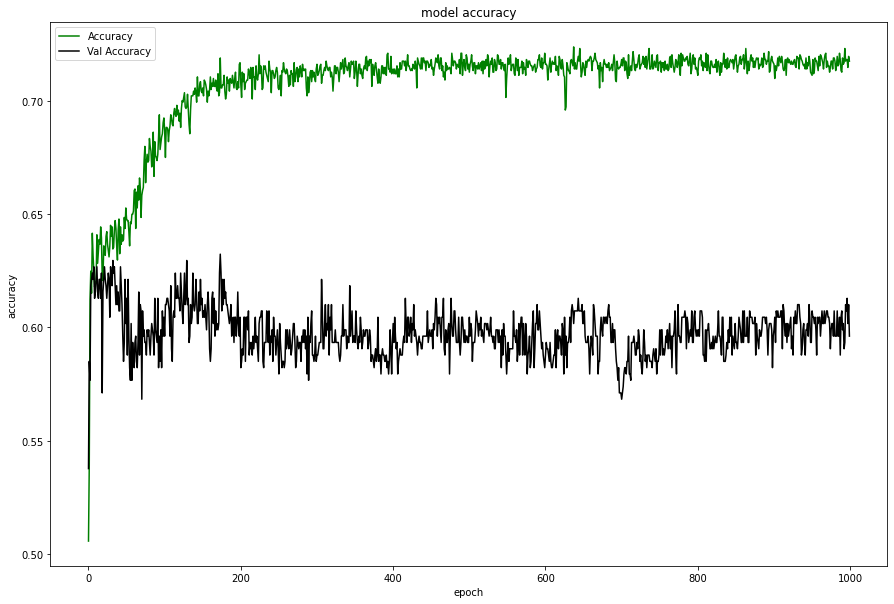

In [60]:
# Cool plotting of the Accuracy and val Accuracy of our model
fig = plt.figure(figsize=(15, 10))
plt.plot(fitData.history['accuracy'], color='g')
plt.plot(fitData.history['val_accuracy'], color='black')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Val Accuracy'], loc='upper left')

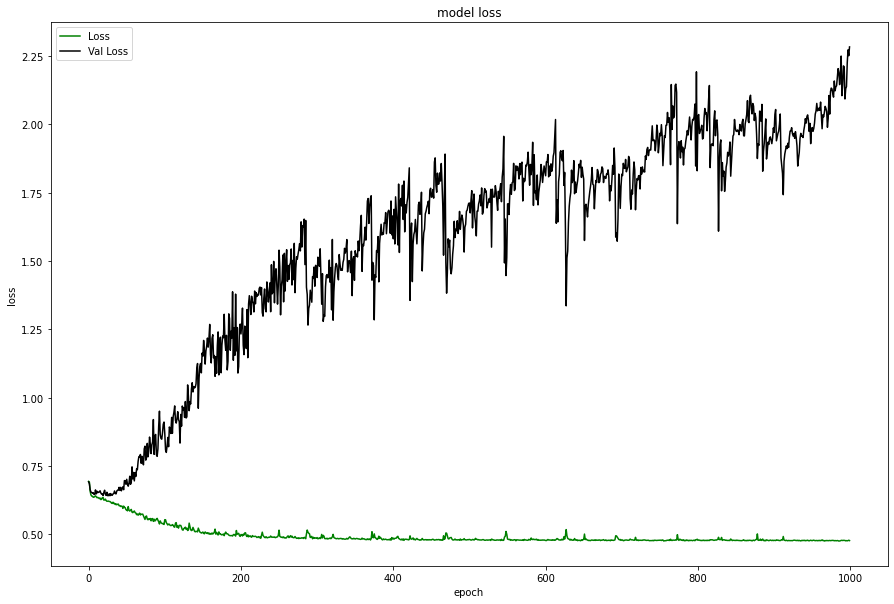

In [61]:
# Cool plotting of the loss and val loss of our model
fig = plt.figure(figsize=(15, 10))
plt.plot(fitData.history['loss'], color='g')
plt.plot(fitData.history['val_loss'], color='black')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Loss', 'Val Loss'], loc='upper left')

# Make a prediction

In [68]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post')

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.

Prediction = Review_m.predict(padded)
to_word_label(Prediction)

# This shows how terrible the model is at classifying the data. It literally did the opposite for
# all the values. It negatively classified the positive revies and positively classified
# the negative reviews. That's very weird.

['negative', 'positive', 'negative', 'positive', 'negative']